In [1]:
import sys
import pymol
from pymol import cmd, stored

In [2]:
pymol.pymol_argv = ['pymol', '-qc'] # quiet / no GUI
stdout = sys.stdout
stderr = sys.stderr
pymol.finish_launching(['pymol', '-xiq'])
sys.stdout = stdout
sys.stderr = stderr

/Users/karen/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/karen/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


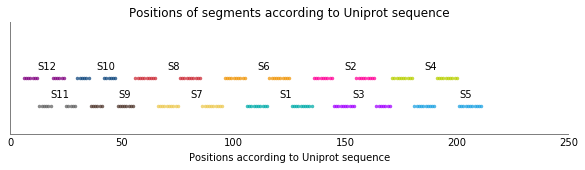

Calculating changes in properties:
   Average residue mass (daltons)
   Monoisotopic mass (daltons)
   Occurrence in proteins, %
   Average volume of buried residues, A3
   Van der Waals volume, A3
   Accessible surface area, A2
   Fraction of buried among this aa
   Fraction of buried among all buried
   Polarity average ranking
   Polarity ranking (Radzicka and Wolfenden 1988)


/Users/karen/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:1101: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['aa_seq', 'mut_list', 'mut_list_Scer', 'mut_list_Scer_full']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


1886 unique mutations across all segments
238 natural unique mutations across all segments
There are 231 single mutations with known effects. They are found in 120 positions


Now the following variables are available:

- data: all data as a (sorted) dictionary in the form: 'segment_name': 'segment_data_as_pandas_dataframe'

- unique_single_mutations: a dictionary with all single mutations for every segment

- data_singles: a sorted dictionary in the form: 'segment_name': 'segment_data_as_pandas_dataframe' for genotypes containing a single substitution

- single_mut_fitness_dict: a dictionary in the form: 'single mutation' : 'fitness'

- data_known_mutations_only: a sorted dictionary in the form: 'segment_name': 'segment_data_as_pandas_dataframe', 
but only for those genotypes that consist of mutations with known effects (single mutant is measured).
For this dictionary, epistasis is measured for every genotype

- aa_properties: a pandas DataFrame summarizing properties of amino acids,


In [3]:
%run 'ks08_Epistasis_in_all_backgrounds.ipynb'
notebook_prefix = 'ks10'
image_counter = Counter()
session_counter = Counter()

### Plotting distribution of epistasis values

In [4]:
needed = False
if needed:
    bar_color = '#6e6e83'
    for segment in data:
        print segment, '...'
        folder_to_save = check_dir(os.path.join(figures_folder, 'epistasis_histograms', segment, ''))
        for mutA, mutB in ep_dict[segment]:
            ep = ep_dict[segment][mutA, mutB]
            if len(ep) > minimal_N:
                plot_better()
                mean, std = ep.mean(), ep.std()
                plt.axvline(mean, color='magenta')
                plt.axvline(std, color='orange')
                title = 'Segment %s \nepistasis between mutations %s and %s\nmean = %.2f, std = %.2f' %(segment.split('_')[0], 
                                                                                                    mutA, mutB,
                                                                                                   mean, std)
                plt.hist(ep.values, edgecolor='none', range=(-0.6, 0.6), bins=120, color=bar_color)
                plt.title(title)
                plt.xlabel('Epistasis')
                plt.ylabel('Number of different backgrounds')
                plt.xlim(-0.6,0.6)
                plt.axvline(0, color='gray', ls='-')
                plt.tight_layout()
                save_image(image_counter, title[:title.index('\nmean')], 
                           check_dir(os.path.join(folder_to_save, 'positions_'+mutA[:-1]+'-'+mutB[:-1], '')), 
                           notebook_prefix)
                plt.close()

## Epistasis vs predicted ddG

In [13]:
rosetta_folder = os.path.join(analysis_folder, 'Sasha', 'rosetta_runs', '')
predicted_ddG = pd.read_table(rosetta_folder + 'run-170503-results.csv')
predicted_ddG['mut_number'] = predicted_ddG['mut_list_Scer'].apply(lambda s: s.count(':')+1)
predicted_ddG['mut_list_Scer_full'] = predicted_ddG['mut_list_Scer'].apply(convert_to_full_mutations)
for aa_property in quantitative_properties:
        predicted_ddG['Abs change in ' + aa_property.lower()] = predicted_ddG['mut_list_Scer_full'].apply(
            lambda mut_comb: cumulative_property_change(mut_comb, aa_property))

predicted_doubles = predicted_ddG[predicted_ddG['mut_number'] == 2].copy()

In [14]:
ep_dict_pandas = OrderedDict()
for segment in ep_dict:
    ep_dict_pandas[segment] = pd.DataFrame.from_dict(ep_dict[segment])

In [15]:
def get_segment_ep(segment, sorted_mut_pair):
    mutA, mutB = sorted_mut_pair[0], sorted_mut_pair[1]
    assert len(sorted_mut_pair) == 2
    assert mutA == sorted(list((mutA, mutB)), key=lambda m: int(m[:-1]))[0]
    ep_data = ep_dict_pandas[segment]
    try:
        return ep_data[mutA][mutB][~np.isnan(ep_data[mutA][mutB])]
    except:
#         print segment, mutA, mutB, len(sorted_mut_pair) == 2, ' -- failed to find'
        return pd.Series.from_array([0, np.nan])

def get_fraction_strong(ep_series, abs_strong_epistasis_threshold=strong_epistasis_threshold, sign='absolute_value'):
    assert sign in ['absolute_value', 'positive', 'negative']
    if sign == 'absolute_value':
        return 1. * len(ep_series[np.abs(ep_series) > strong_epistasis_threshold]) / len(ep_series)
    if sign == 'positive':
        return 1. * len(ep_series[ep_series > strong_epistasis_threshold]) / len(ep_series)
    if sign == 'negative':
        return 1. * len(ep_series[ep_series < -1 * strong_epistasis_threshold]) / len(ep_series)
    

predicted_doubles['ep_mean'] = predicted_doubles.apply(
    lambda df: get_segment_ep(df[u'segment'], df['mut_list_Scer'].split(':')).mean(), axis=1)

predicted_doubles['ep_median'] = predicted_doubles.apply(
    lambda df: get_segment_ep(df[u'segment'], df['mut_list_Scer'].split(':')).median(), axis=1)

predicted_doubles['ep_std'] = predicted_doubles.apply(
    lambda df: get_segment_ep(df[u'segment'], df['mut_list_Scer'].split(':')).std(), axis=1)

predicted_doubles['ep_fraction_strong'] = predicted_doubles.apply(
    lambda df: get_fraction_strong(get_segment_ep(df[u'segment'], df['mut_list_Scer'].split(':')), abs_strong_epistasis_threshold=0.2), axis=1)

predicted_doubles['ep_fraction_strong_pos'] = predicted_doubles.apply(
    lambda df: get_fraction_strong(get_segment_ep(df[u'segment'], df['mut_list_Scer'].split(':')), 
                                   abs_strong_epistasis_threshold=0.2, sign = 'positive'), axis=1)

predicted_doubles['ep_fraction_strong_neg'] = predicted_doubles.apply(
    lambda df: get_fraction_strong(get_segment_ep(df[u'segment'], df['mut_list_Scer'].split(':')), 
                                   abs_strong_epistasis_threshold=0.2, sign = 'negative'), axis=1)

In [18]:
printlist(predicted_doubles.columns)

aa_seq
mut_list_Scer
ddg_score1
ddg_score2
ddg_score3
segment
mut_number
mut_list_Scer_full
Abs change in average residue mass (daltons)
Abs change in monoisotopic mass (daltons)
Abs change in occurrence in proteins, %
Abs change in average volume of buried residues, a3
Abs change in van der waals volume, a3
Abs change in accessible surface area, a2
Abs change in fraction of buried among this aa
Abs change in fraction of buried among all buried
Abs change in polarity average ranking
Abs change in polarity ranking (radzicka and wolfenden 1988)
ep_mean
ep_median
ep_std
ep_fraction_strong
ep_fraction_strong_pos
ep_fraction_strong_neg



Abs change in average residue mass (daltons)
Abs change in monoisotopic mass (daltons)
Abs change in occurrence in proteins, %
Abs change in average volume of buried residues, a3
Abs change in van der waals volume, a3
Abs change in accessible surface area, a2
Abs change in fraction of buried among this aa
Abs change in fraction of buried among all buried
Abs change in polarity average ranking
Abs change in polarity ranking (radzicka and wolfenden 1988)


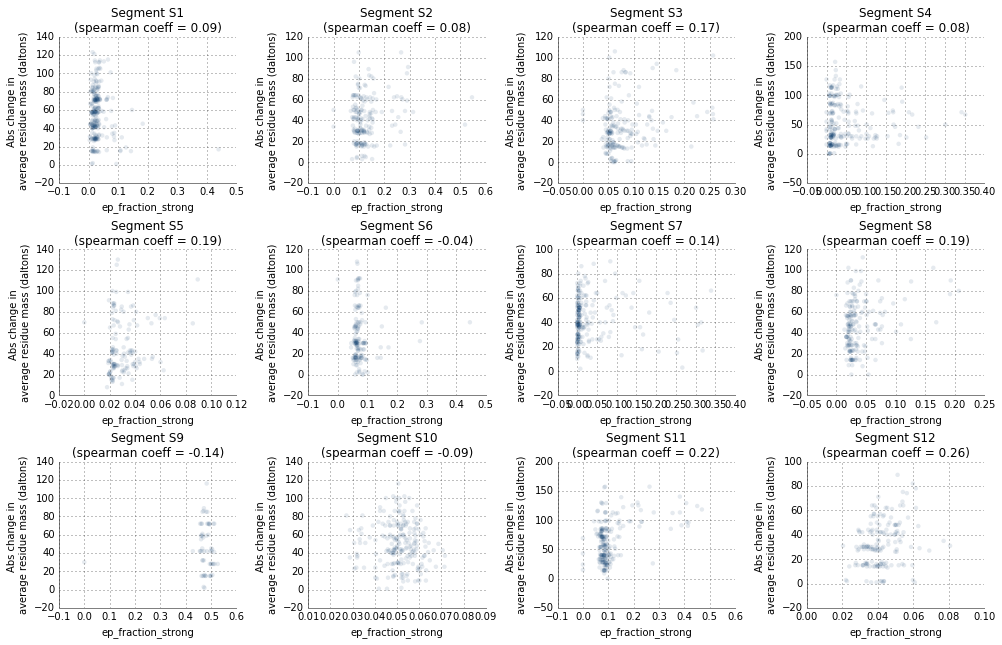

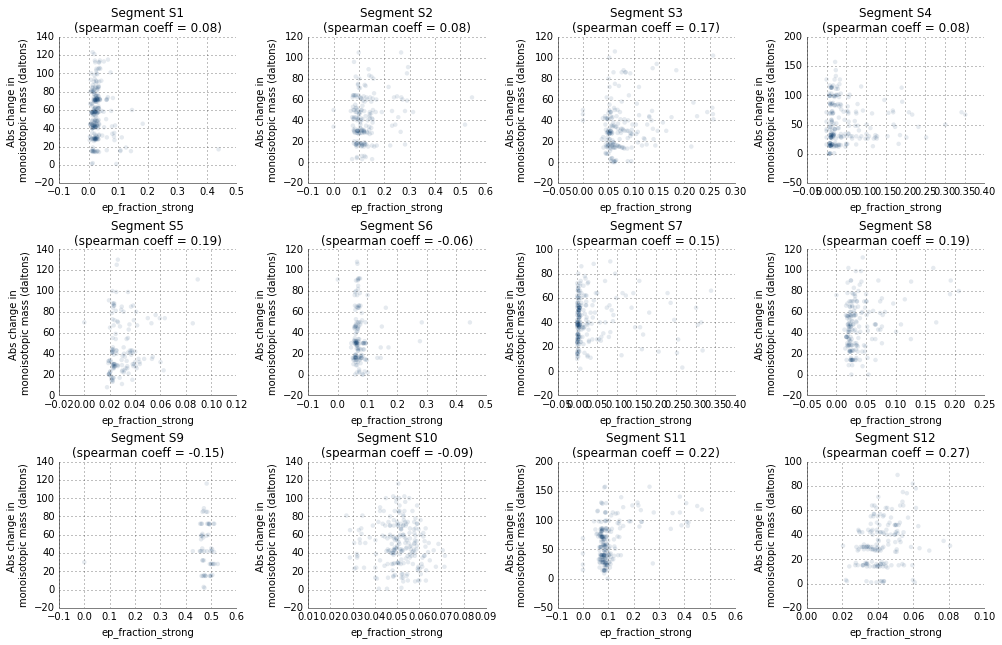

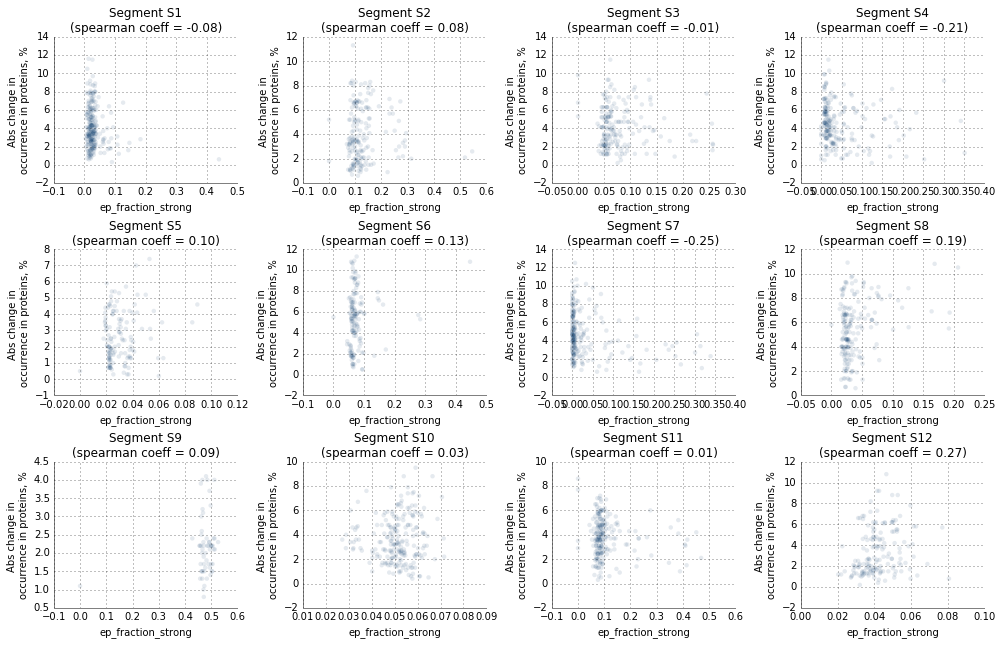

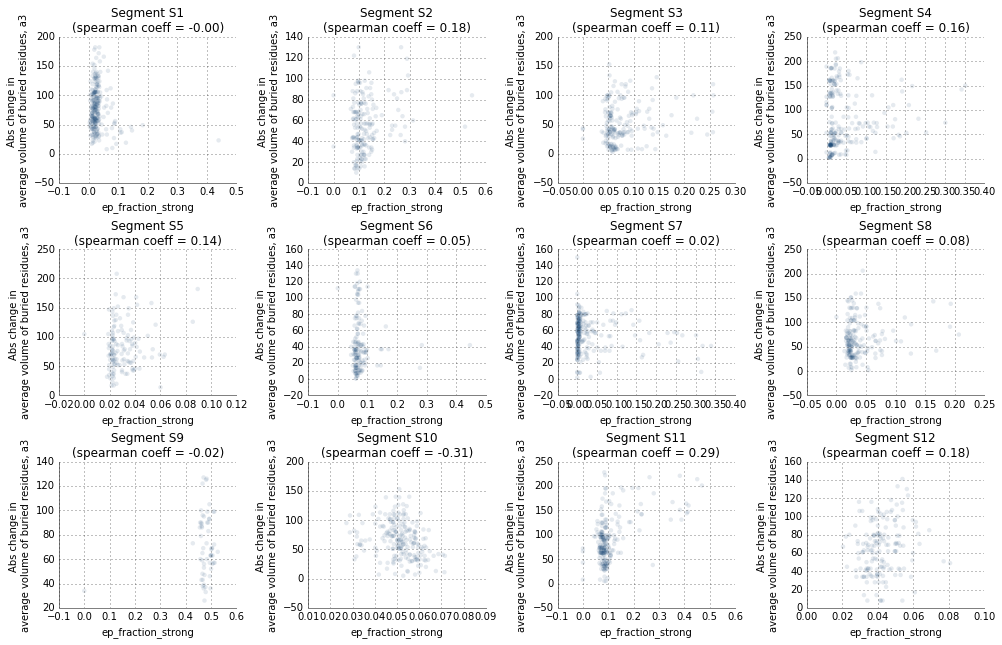

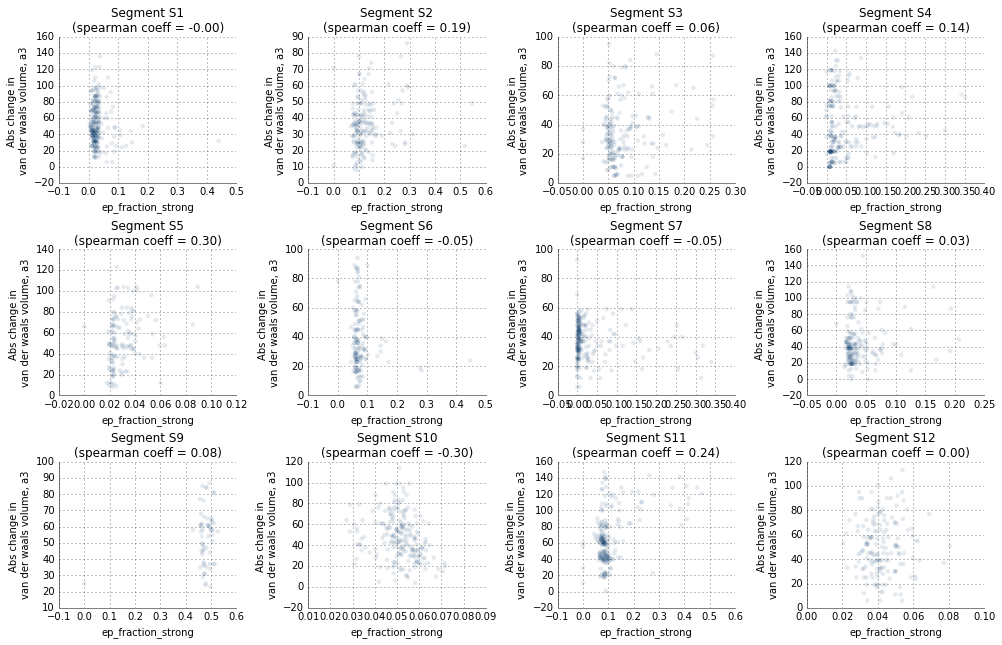

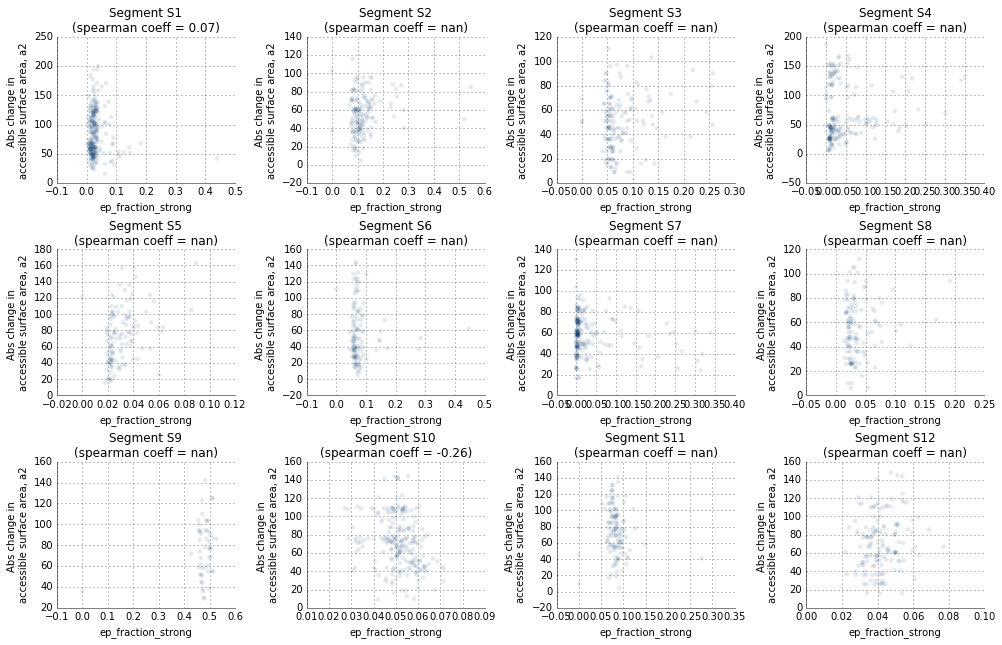

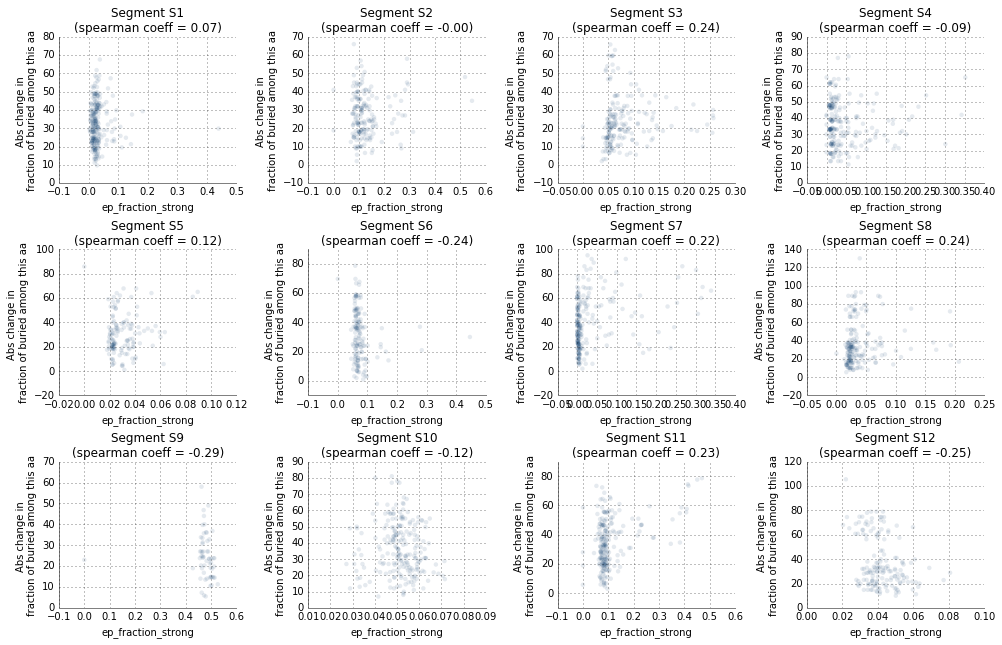

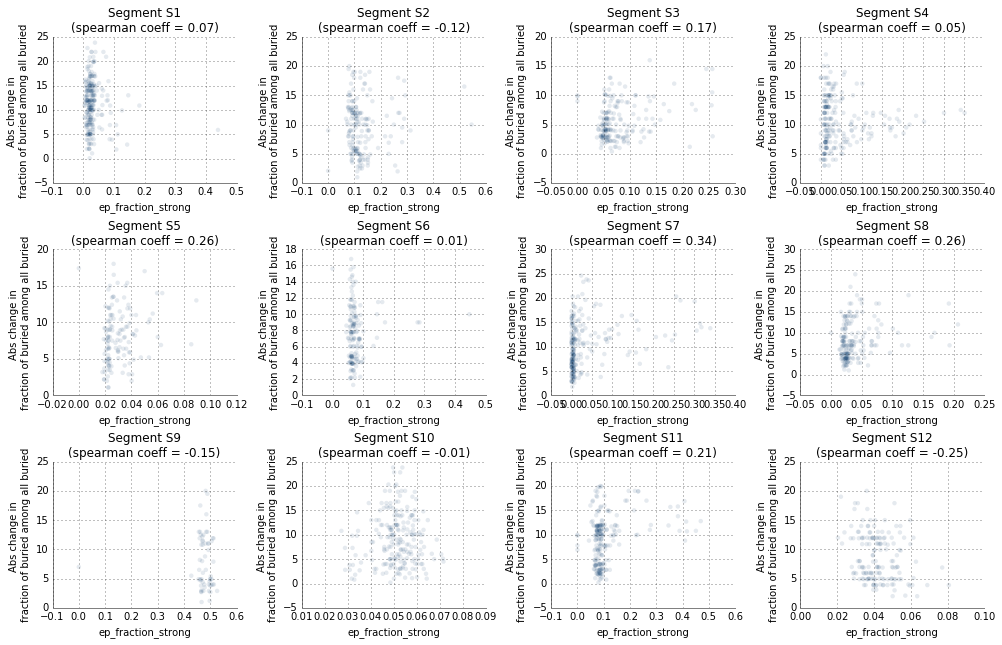

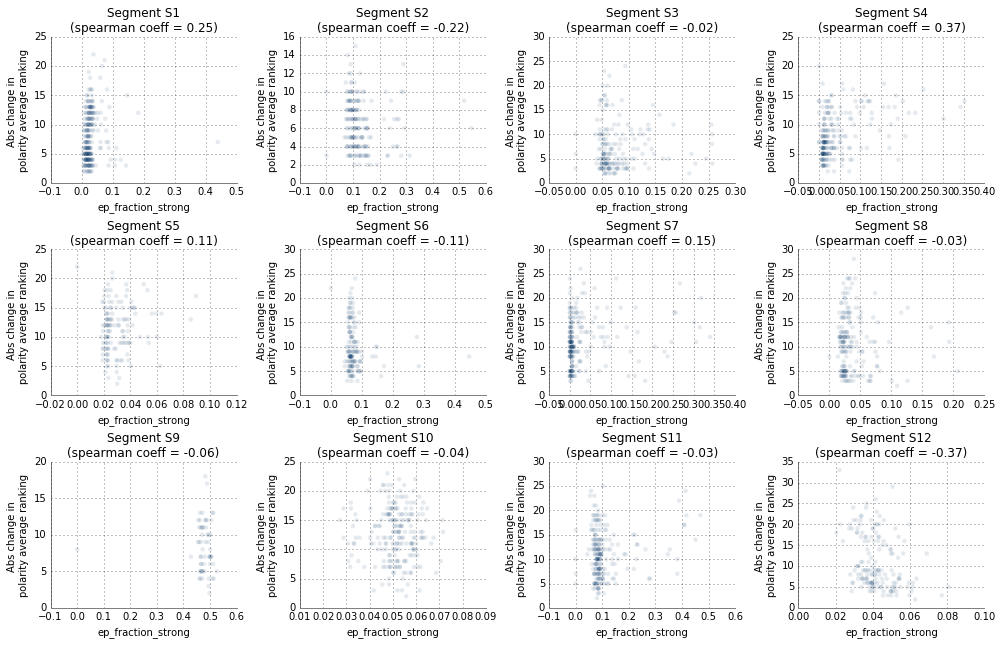

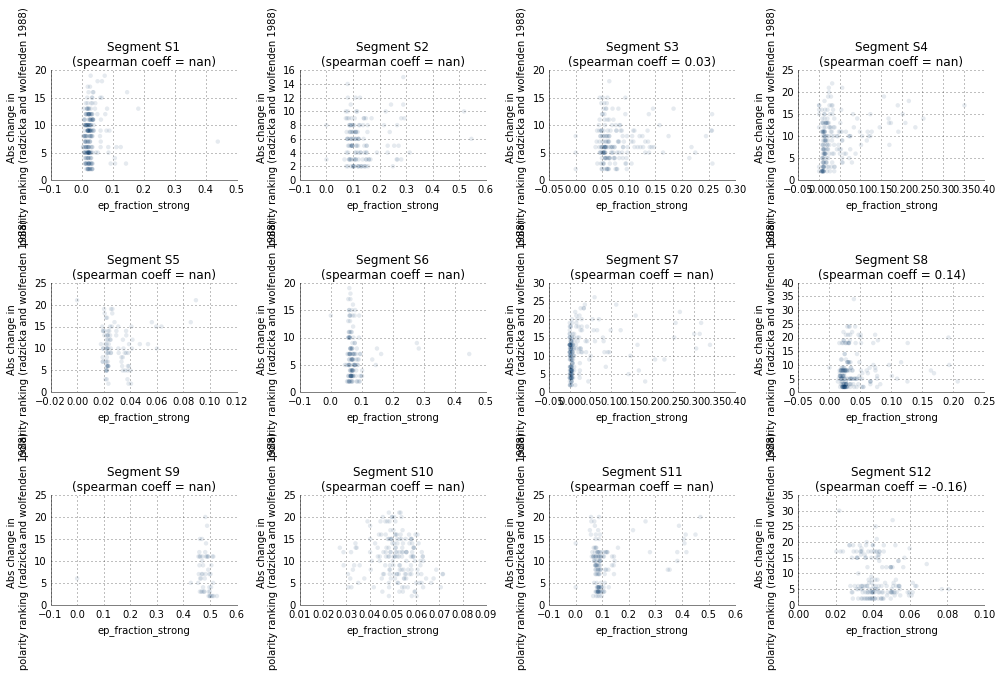

In [27]:
color_positive = '#E91348'
color_negative = '#003366'

x = u'ep_fraction_strong'
for y in [c for c in predicted_doubles.columns if 'Abs' in c]:
    print y
    plot_better(width=14, height=9)
    title ='%s vs %s in double mutants' % (x,y)
    for index, segment in enumerate(data.keys()):
        to_plot = predicted_doubles[predicted_doubles.segment == segment]
        ax = plt.subplot(3,4,index+1)
        improve_plot(ax)
        plt.scatter(to_plot[x],to_plot[y], edgecolor='none', alpha=0.1, color=color_negative)
        spearman = stats.spearmanr(to_plot[x],to_plot[y])
        subtitle = 'Segment %s' %(segment.split('_')[0])
        subtitle += '\n(spearman coeff = %.2f)' %spearman[0]
        plt.title(subtitle)
    #     plt.ylim(0,0.7)
    #     plt.xlim(-570, -520)
    #     plt.axvline(0, color='gray')
        plt.xlabel(x)
        plt.ylabel(y[:14]+'\n'+y[14:])
    plt.tight_layout()
    save_image(image_counter, title, figures_folder, notebook_prefix)